# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [3]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [4]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)

bias = -2
noise = np.random.randn(n)/5
Y = np.dot(X, true_w).reshape(n) + bias + noise

def calc_linreg(X):
    X_additional = np.hstack([np.ones([X.shape[0], 1]), X])
    true_w_bias = np.vstack([bias, true_w])
    return np.dot(X_additional, true_w_bias).reshape(n)

print('best_possible_mse:', np.mean(np.power(Y-calc_linreg(X), 2)))

best_possible_mse: 0.041121078015853456


In [5]:
Y = Y.reshape(-1, 1)

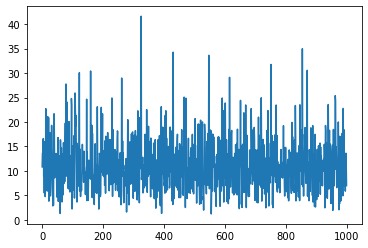

In [6]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(10, 1, True), 
    torch.nn.ReLU(True)
    )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), 1e-1)
epochs = 10
batch_size = 10

history = []
for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        x = torch.tensor(x).float()
        y_true = torch.tensor(y_true).float()

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y_true)
        history.append(loss.item())
        loss.backward()
        optimizer.step()

plt.plot(history)

In [7]:
for param in model.parameters():
    print(param.detach().numpy().reshape(-1))

print()
print(true_w.reshape(-1), bias)

[ 0.7138491   0.7233059  -0.9320493  -0.8751654   1.2096502   0.47604018
  1.306382    0.31288666 -0.5390918  -1.2388363 ]
[-2.006581]

[ 0.76004232  0.73859784 -0.94280631 -0.88489711  1.22103973  0.45579815
  1.32588355  0.30926302 -0.53442312 -1.24735747] -2


### Модель

In [8]:
model = Sequential(
    Linear(10, 1, bias=True),
    ReLU(),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [9]:
epochs = 10
batch_size = 10
learning_rate = 1e-1
optimizer = SGD(learning_rate)

23.05496714352304
11.139784669478079
19.7905692091823
18.58148272033859
17.73729223360036
6.206531824478582
14.690170050220171
6.12714580449426
15.074886286344219
10.292261042710438
19.400781489840206
16.629295227010314
26.250789764133323
14.447621836765217
9.466279708638677
12.93529128582253
5.628499429051006
19.248195850514698
8.35580475409087
5.451110205504709
10.250941749033599
7.721381559566112
5.469495449217923
15.205821733751824
21.61376019086888
11.032617613197452
6.195841410967486
5.188430326165725
16.032496290501005
5.961620430725578
5.495351057422331
7.562256963688364
10.36254179059122
14.679360501506224
12.145082794460821
21.187772025363056
20.910816457927076
6.375390145514202
10.393655265260502
8.190377346751948
3.9206095532502103
12.169147893167768
14.31393225973805
12.629892179718073
24.48421235448851
4.585738774882301
8.682162435605981
30.58683529730855
15.594076640630082
5.3610365099202015
13.859594194212011
4.196808383172856
15.79574121589516
9.421414538395847
10.8519

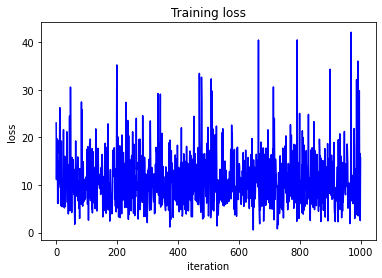

In [10]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        optimizer(model.parameters(),
            model.grad_parameters())
        
        #print(model.layers[0].W[0][0])
        print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [11]:
print("Ground truth")
print(true_w.reshape(-1), bias)
print("Model")
print([m.reshape(-1) for m in model.parameters()])

Ground truth
[ 0.76004232  0.73859784 -0.94280631 -0.88489711  1.22103973  0.45579815
  1.32588355  0.30926302 -0.53442312 -1.24735747] -2
Model
[array([ 0.61224586,  0.65093232, -0.79851864, -0.74532529,  1.02621126,
        0.41152898,  1.11795149,  0.27973813, -0.48802323, -1.06104726]), array([-1.42528962])]


# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

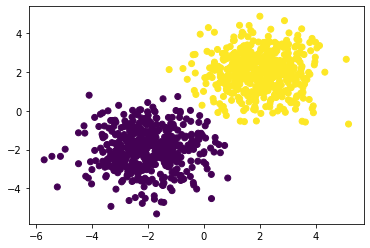

In [12]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [13]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [14]:
epochs = 10
batch_size = 16
learning_rate = 1e-2
optimizer = SGD(learning_rate)

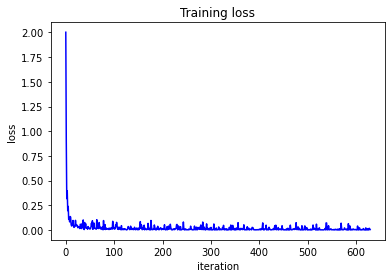

In [15]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        optimizer(model.parameters(),
            model.grad_parameters())
        
        # логгируем лосс
        history.append(loss.mean())

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

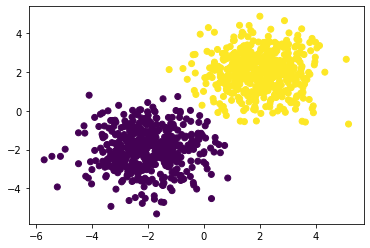

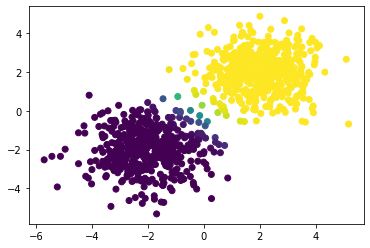

In [16]:
plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

plt.scatter(X[:,0], X[:,1], c=model(X)[:, 0])
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [17]:
import os
from sklearn.datasets import fetch_openml 
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    data = np.load("mnist.npz", allow_pickle=True)
    X = data['X']
    y = data['y']
else:
    mnist = fetch_openml("mnist_784")
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = np.array(mnist.data / 255.0)
    y = np.array(mnist.target.astype(int))
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [18]:
def onehot(y):
    y_onehot = np.zeros(shape=(len(y), 10))
    y_onehot[np.arange(len(y)), y] = 1
    return y_onehot

def predict2class(predict):
    return predict.argmax(axis=1)

assert (predict2class(onehot(y)) == y).all(), "Something go wrong with onehot encode/decode!"

Разделите датасет на train и validation.

In [19]:
def train_test_split(X, y, test_size):
    train_end = int(np.ceil(len(X)*(1-test_size)))
    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, onehot(y), .2)

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

## Метрики

In [20]:
def precision(y_pred, y_true):
    assert len(y_pred.shape) == 1 and len(y_true.shape) == 1,\
        "y_pred and y_true must be vector of classes"
    assert y_pred.size == y_true.size,\
        "y_pred and y_true must have the same size"
    classes = np.unique(y_true)
    precisions = []
    for i in classes:
        tp = np.logical_and((y_pred==i), (y_true==i)).sum()
        fp = np.logical_and((y_pred==i), (y_true!=i)).sum()
        precisions.append(tp/(tp+fp))
    return np.array(precisions)

In [21]:
def recall(y_pred, y_true):
    assert len(y_pred.shape) == 1 and len(y_true.shape) == 1,\
        "y_pred and y_true must be vector of classes"
    assert y_pred.size == y_true.size,\
        "y_pred and y_true must have the same size"
    classes = np.unique(y_true)
    recalls = []
    for i in classes:
        tp = np.logical_and((y_pred==i), (y_true==i)).sum()
        fn = np.logical_and((y_pred!=i), (y_true==i)).sum()
        recalls.append(tp/(tp+fn))
    return np.array(recalls)

In [22]:
def f_score(y_pred, y_true, beta=1):
    prec = precision(y_pred, y_true)
    rec = recall(y_pred, y_true)
    beta_square = beta**2
    return ((1+beta_square)*prec*rec)/(prec+rec*beta_square)

In [23]:
def confusion_matrix(y_pred, y_true):
    assert len(y_pred.shape) == 1 and len(y_true.shape) == 1,\
        "y_pred and y_true must be vector of classes"
    assert y_pred.size == y_true.size,\
        "y_pred and y_true must have the same size"
    classes = np.unique(y_true)
    classes.sort()
    conf_m = np.zeros(shape=(len(classes), len(classes)))
    for i in classes:
        for j in classes:
            conf_m[i, j] = np.logical_and((y_pred==i), (y_true==j)).sum()
    return conf_m, classes

In [24]:
def accuracy(y_pred, y_true):
    assert len(y_pred.shape) == 1 and len(y_true.shape) == 1,\
        "y_pred and y_true must be vector of classes"
    assert y_pred.size == y_true.size,\
        "y_pred and y_true must have the same size"
    return (y_pred==y_true).sum()/y_true.size

In [25]:
def _space_add(x, min_len=10):
    return " "*(min_len-len(x)) + x if len(x) < min_len else x

In [26]:
def print_log(accuracy_val, accuracy_train=None, spaces=10, **vec_metrics):
    columns = " "
    rows = [str(i) for i in range(10)]
    for metric_name, data in vec_metrics.items():
        columns += _space_add(metric_name, spaces)
        for i in range(10):
            rows[i] += _space_add("%.4f" % data[i], spaces)

    if len(rows[0]) > 1:
        print(columns)
        print("\n".join(rows) + "\n")
    if accuracy_train is not None:
        print("accuracy_train: %.4f" % accuracy_train)
    print("accuracy_val: %.4f" % accuracy_val)

In [27]:
def print_confusion_matrix(conf_m, classes, spaces=10):
    rows = [" " + "".join([_space_add(str(x), spaces) for x in range(10)]) + " true"]
    for i, cl in enumerate(classes):
        s = str(cl) + "".join([_space_add("%d" % x, spaces) for x in conf_m[i]]) 
        rows.append(s)
    print("\n".join(rows))
    print("pred")

## Обучение

In [28]:
from IPython.display import clear_output

In [29]:
# 0 - просто эпоха
# 1 - +accuracy_val
# 2 - +accuracy_train
# 3 - +f_score, precision, recall
VERBOSITY = 2
CLEAR_OUTPUT = False

learning_rate = 1e-3
batch_size = 128
epochs = 60

In [30]:
model = Sequential(
    Linear(784, 300),
    LeakyReLU(),
    Dropout(.4),
    BatchNorm(300),
    Linear(300, 300),
    LeakyReLU(),
    Dropout(.4),
    BatchNorm(300),
    Linear(300, 300),
    LeakyReLU(),
    Dropout(.4),
    BatchNorm(300),
    Linear(300, 10),
    SoftMax()
)

criterion = CrossEntropy()
optimizer = Nadam(learning_rate)

In [31]:
history = {
    "train_loss":[], "val_loss":[], 
    "accuracy_train":[], "accuracy_val":[],
    }
for epoch in range(1, epochs+1):
    # Train
    train_losses = []
    y_pred_l = []
    y_true_l = []
    for x, y in loader(X_train, y_train, batch_size=batch_size):
        y_pred = model(x)
        loss = criterion(y_pred, y)

        grad = criterion.backward(y_pred, y)
        model.backward(x, grad)
        
        optimizer(model.parameters(), model.grad_parameters())
        if VERBOSITY > 1:
            y_pred_l.append(y_pred)
            y_true_l.append(y)
        train_losses.append(loss)
    accuracy_train = accuracy(
        predict2class(np.vstack(y_pred_l)), predict2class(np.vstack(y_true_l))
    ) if VERBOSITY > 1 else None

    # Validation
    val_losses = []
    y_pred_l = []
    y_true_l = []
    model.eval()
    for x, y in loader(X_test, y_test, batch_size=batch_size):
        y_pred = model(x)
        loss = criterion(y_pred, y)
        if VERBOSITY > 0:
            y_pred_l.append(y_pred)
            y_true_l.append(y)
        val_losses.append(loss)
    model.train()

    # metrics
    if VERBOSITY > 0:
        y_pred= predict2class(np.vstack(y_pred_l))
        y_true = predict2class(np.vstack(y_true_l))
        accuracy_val = accuracy(y_pred, y_true)
        if VERBOSITY > 2:
            f1_score = f_score(y_pred, y_true)
            precision_score = precision(y_pred, y_true)
            recall_score = recall(y_pred, y_true)
    # history
    history["train_loss"].append(np.mean(np.hstack(train_losses)))
    history["val_loss"].append(np.mean(np.hstack(val_losses)))
    if VERBOSITY > 0:
        history["accuracy_val"].append(accuracy_val)
    if VERBOSITY > 1:
        history["accuracy_train"].append(accuracy_train)
    #
    metrics = dict(
        f1_score=f1_score, 
        precision=precision_score, 
        recall=recall_score
    ) if VERBOSITY > 2 else dict()
    print("epoch %d" % epoch)
    if VERBOSITY > 0:
        print_log(accuracy_val, accuracy_train, **metrics)
    if CLEAR_OUTPUT:
        clear_output(True)


epoch 1
accuracy_train: 0.8948
accuracy_val: 0.9645
epoch 2
accuracy_train: 0.9442
accuracy_val: 0.9703
epoch 3
accuracy_train: 0.9549
accuracy_val: 0.9785
epoch 4
accuracy_train: 0.9610
accuracy_val: 0.9784
epoch 5
accuracy_train: 0.9627
accuracy_val: 0.9796
epoch 6
accuracy_train: 0.9677
accuracy_val: 0.9809
epoch 7
accuracy_train: 0.9689
accuracy_val: 0.9812
epoch 8
accuracy_train: 0.9698
accuracy_val: 0.9811
epoch 9
accuracy_train: 0.9730
accuracy_val: 0.9821
epoch 10
accuracy_train: 0.9747
accuracy_val: 0.9802
epoch 11
accuracy_train: 0.9749
accuracy_val: 0.9831
epoch 12
accuracy_train: 0.9750
accuracy_val: 0.9820
epoch 13
accuracy_train: 0.9762
accuracy_val: 0.9830
epoch 14
accuracy_train: 0.9781
accuracy_val: 0.9822
epoch 15
accuracy_train: 0.9789
accuracy_val: 0.9839
epoch 16
accuracy_train: 0.9802
accuracy_val: 0.9850
epoch 17
accuracy_train: 0.9797
accuracy_val: 0.9838
epoch 18
accuracy_train: 0.9801
accuracy_val: 0.9847
epoch 19
accuracy_train: 0.9818
accuracy_val: 0.9848
ep

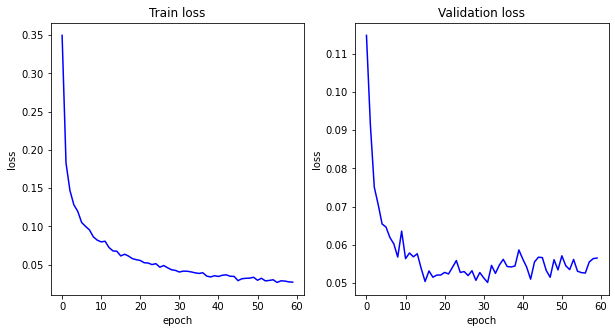

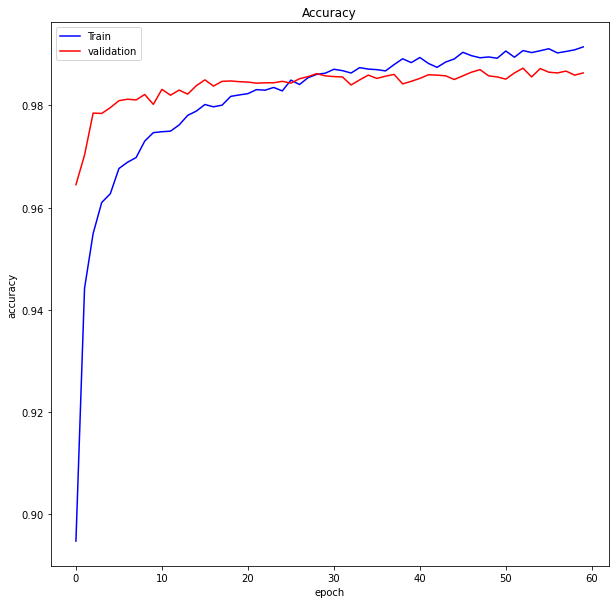

-------------------------------------------------- Confusion Matrix --------------------------------------------------
          0         1         2         3         4         5         6         7         8         9 true
0      1361         0         1         0         0         2         2         0         4         2
1         1      1557         0         0         2         0         2         7         2         3
2         1         1      1421         2         3         0         0        10         3         1
3         1         5         1      1400         0        16         1         3         0         7
4         0         0         1         0      1357         1         3         1         3        11
5         1         1         0         2         0      1222         3         0         3         7
6         2         3         0         0         3         6      1328         0         0         0
7         1         0         5         3         2         

In [32]:
def plot_loss(figsize=(10, 5)):
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    ax1.plot(history["train_loss"], c="blue")
    ax2.plot(history["val_loss"], c="blue")
    ax1.set_title('Train loss')
    ax2.set_title('Validation loss')
    for ax in ax1, ax2:
        ax.set_ylabel("loss")
        ax.set_xlabel("epoch")
    plt.show()
    
def plot_accuracy(figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    if history.get("accuracy_train", False):
        ax.plot(history["accuracy_train"], c="blue", label="Train")
    ax.plot(history["accuracy_val"], c="red", label="validation")
    ax.set_title("Accuracy")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.legend()
    plt.show()

plot_loss()
plot_accuracy()
print("-"*50, "Confusion Matrix", "-"*50)
print_confusion_matrix(*confusion_matrix(y_pred, y_true))